# Lineage Tracking for Cells in the Mother Machine

In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML

### comment out ###
# from jupyterthemes import jtplot
# jtplot.style(theme='oceans16')
%load_ext autoreload

In [2]:
%autoreload 2

### Data Preprocessing

The cell properties data can be obtained from `skimage.measure.regionprops` on the masked trench images. There is a built-in feature extractor in MMLT.

In [3]:
# from LineageTrack.measure_properties import generate_csv

# exp_dir = "D:\\UROP-Data\\"
# mask_dir = exp_dir + "binary_masks\\"
# channel_image_dir = exp_dir + "trenches\\"
# fov_list = ["000", "001", "002", ...]
# Parallel(n_jobs=-1)(delayed(generate_csv)(f"xy{fov}", mask_dir, channel_image_dir, 3, 
#                                          "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\FOV{}\\".format(fov) + "prop\\", 
#                                          30, ['PC', 'mCherry', 'YFP']) 
#                    for fov in fov_list)

Load the properties of cells from a directory containing the csv files **only** or load it with paths to every single file

In [4]:
directory = "G:/Cambridge/MENG/IIB_Project/Data/Phage20220719/data_xy018_mCherry_TR1_.csv"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(1))
# or
# filepath1 = ""
# filepath2 = ""
# ...
# exp = LineageTrack.from_path(filepath1, filepath2, ...)

Looking for data at these locations:
G:/Cambridge/MENG/IIB_Project/Data/Phage20220719/data_xy018_mCherry_TR1_.csv
Finished loading the data
(3102, 14)

                Read 1 files
                Channels: []
                Properties for each cell: ['area', 'centroid-0', 'centroid-1', 'label', 'local_centroid-0', 'local_centroid-1', 'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length', 'orientation', 'time_(mins)', 'trench_id']
            


,trench_id,time_(mins),label,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,local_centroid-1,local_centroid-0,mean_intensity,max_intensity,min_intensity
0,257,0,1,242,41.287487,7.494517,78.925621,41.070248,-0.003278,3.070248,19.92562,265.830579,339.0,228.0


### Tracking Algorithm: Strategy 3 on the Log Book

*Currently this algorithm is designed for exponential growth*

Model for cell growing: 
>$L_{t+\Delta t} = L_t \times 2^{(\Delta t / \tau)}$

Model for one cell of length $L$ and growth $\delta L$ since it is born dividing during a time interval, $\Delta t$: 
> $Pr(y=divide|\theta) = \Phi( L, \delta L | \theta)$
- $\theta$ is the parameters for adder and sizer model
- $\Phi$ is the skewed normal bivariate CDF, here sizer and adder model is independent of each other.
- Assumptions: Division between cells are independent
- The prior is calculated based on this. For multiples cells, the probabilities are multiplied together

#### STEP 1:
Estimate the growth time constant $\tau$, or the doubling time T, by observing the mother cell in some trenches (they can be the same thing but are measured in different ways here)

User need to select the period, e.g., exponential growth

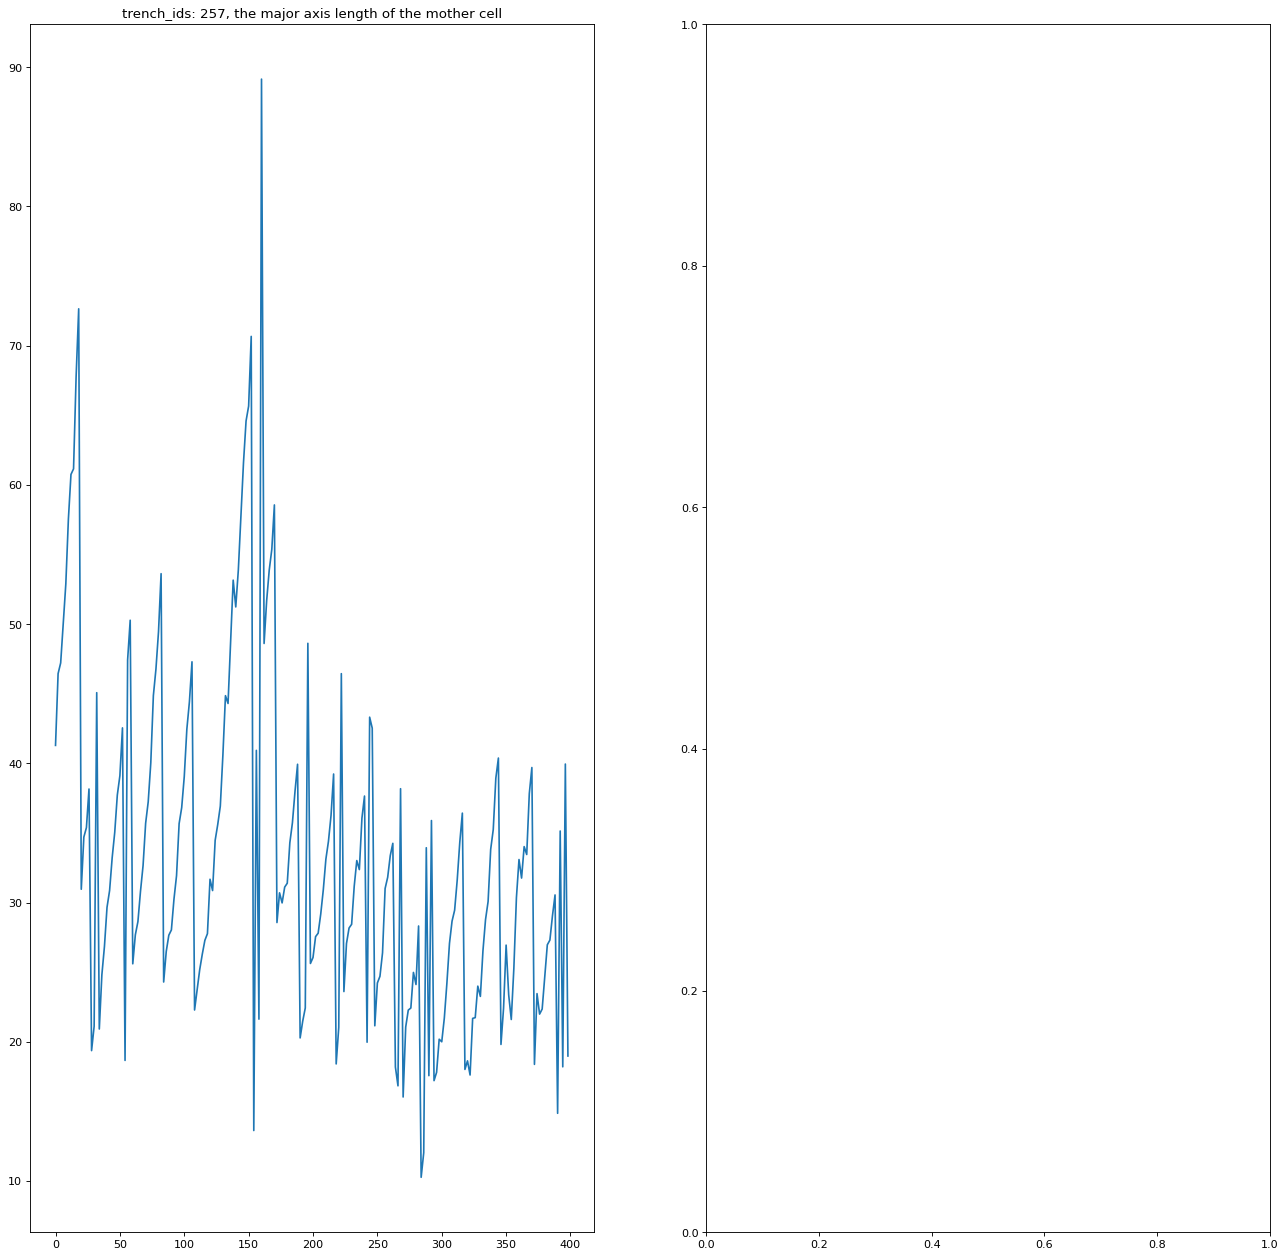

In [5]:
# trench_list = [i for i in range(25)]

m = exp.get_mother_cell_growth(exp.trenches, plot=True)

In [7]:
exp.trenches

[257]

Find the division times for trench 1

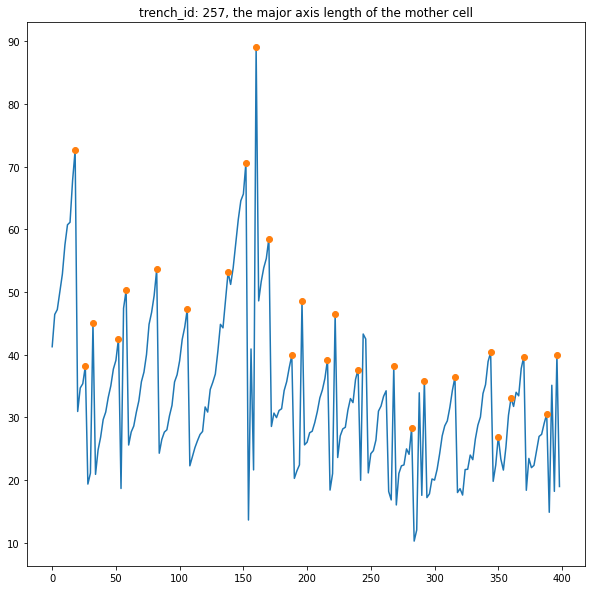

In [9]:
mcell1, idx1 = exp.find_division(trench=257, threshold=1, distance=3, plot=True)

Select the peaks between the exponential growth phase, calculate intervals between division and for each interval, estimate the growth constant

> NOTE: the peak could also be lysis, one way to check is to visualise the mother cell

In [ ]:
peaks = [mcell1[1][i, :] for i in idx1]
peaks = np.array(peaks)
print(peaks)

the slope is estimated to be 0.031005157629851635
the intercept is estimated to be 6.085066465250924


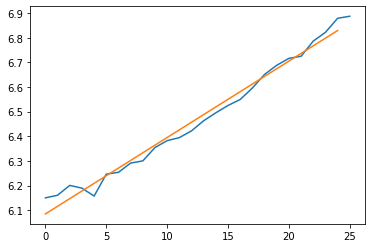

In [11]:
# since we are interested in  exponential growth, slice it according to the data
# in this case data between every peaks can be used
e_phase_idx1 = idx1[:]

exp.collect_model_para(mcell1, e_phase_idx1, plot=True)

In [12]:
print(exp.div_intervals)
print(exp.growth_taus)
print(exp.length_at_div)

[26.0]
[32.252698468373666]
[[[8.0, 34.0], [142.18075561523438, 118.36984252929688]]]


Repeat for trench 2, and so on

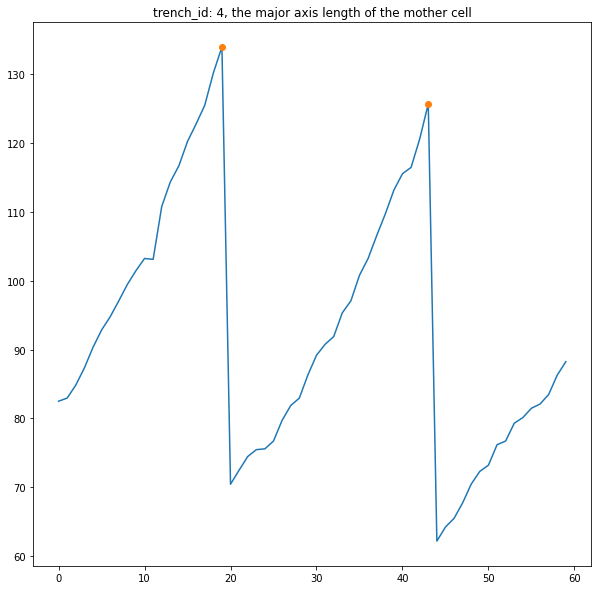

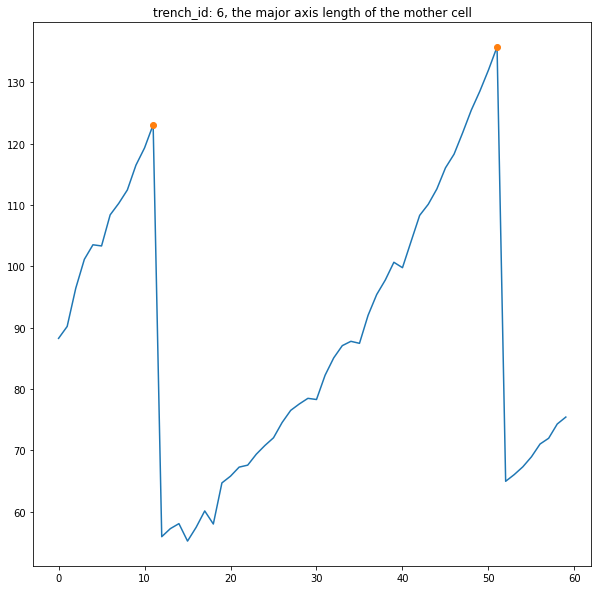

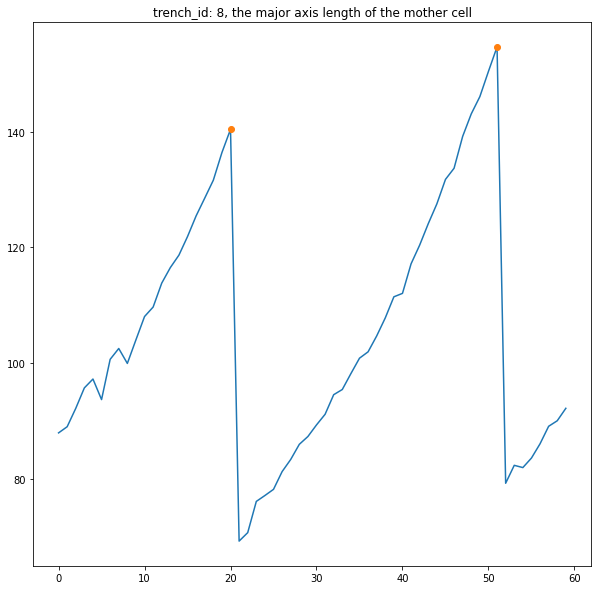

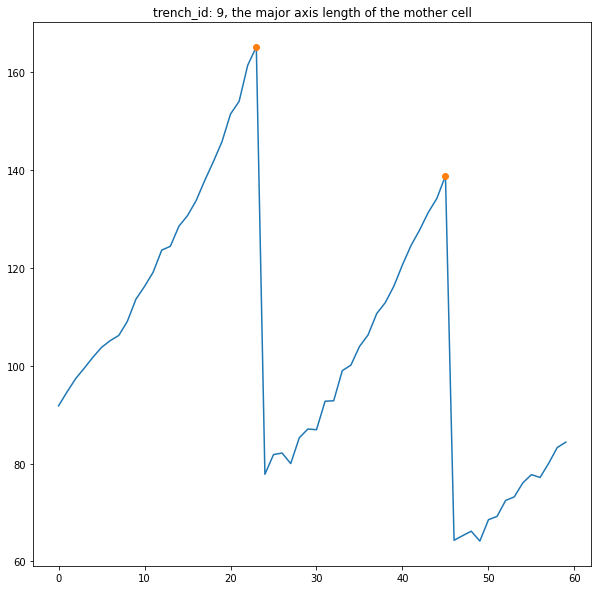

In [18]:
mcell2, idx2 = exp.find_division(4)
mcell3, idx3 = exp.find_division(6, 1, 10)
mcell4, idx4 = exp.find_division(8, 2, 10)
mcell5, idx5 = exp.find_division(9)

In [19]:
exp.collect_model_para(mcell2, idx2[:])
exp.collect_model_para(mcell3, idx3[:])
# slice it according to the data
e_phase_idx4 = idx4[:]    # do not use the last peak
exp.collect_model_para(mcell4, e_phase_idx4)
# this is just to show that collect_model_para only need to be run once for each mother cell
exp.collect_model_para(mcell4, e_phase_idx4)
exp.collect_model_para(mcell5, idx5[:])

In [20]:
exp.update_model_para(model="unif")


                    The average time interval for division is 28.6
                    The time constant for exponential growth is (28.201609575227018, 8.783374914364543)
                    The average division length is 137.79873352050782 
                    with variance 201.9144904097542 and skewness 0.10876027815959902
                    The length for adder model is 65.74219207763672 
                    with variance 262.38494398650363 and skewness 0.8782716085288769
                    


For some cases where you might want to set the parameters manually, e.g., mother cells are not representative of the whole population or cells are growing heterogeneously. Use:

`self.div_interval = some value` - used for setting up prior probability

or, 

`self.growth_tau = some value` - used for estimating the growth of the cells length

Tools to select mode of modelling will be developed later

To include the cells' length into our prior, we need to esimate the skewed Normal cdf parameters. This is done in `update_model_para()`, but can also set manually by `self.sizer_length_para = (mean, var)` and `self.adder_length_para = (mean, var)`. 

`update_model_para(self, model="lineage-trench", Bessel=True)` updates the parameters from our current tracking results of the trench. 

`update_model_para(self, model="lineage-all", Bessel=True)` updates the parameters from our current tracking results of all trenches.

Variance can be corrected by Bessel Correction.

The skewed normal cdf is calculated using an estimation discussed in this paper: 
Amsler, C., Papadopoulos, A., and Schmidt, P. (2021). Evaluating the cdf of the skew normal distribution.

$Pr(div | \delta L, L) = \frac{Pr(div, \delta L, L)}{Pr(L)Pr(\delta L)}$

Since sizer and adder model are assumed to be independent, $Pr(div | \delta L, L) \propto Pr(div|\delta L) Pr(div|L)$

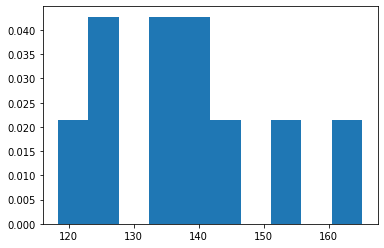

[142.18075561523438, 118.36984252929688, 133.98182678222656, 125.69993591308594, 123.05802917480469, 135.7503204345703, 140.38180541992188, 154.59335327148438, 165.1546173095703, 138.8168487548828]


In [21]:
import matplotlib.pyplot as plt

max_lengths = []
for i in exp.length_at_div:
    max_lengths += i[1]
plt.hist(max_lengths, density=True)
plt.show()
print(max_lengths)

In [22]:
exp.sizer_length_paras

(137.79873352050782, 201.9144904097542)

#### STEP 2:
For each frame in each trench, look at the current frame in the trench and predict a list of furture of the cells in the next frame with some probability (prior) by using the model from above: growth and division. 

Score each furture with a likelihood function, using y position and length. Select the one with the highest value of prior x likelihood. 

$$\textbf{a priori: }p(y=k|\boldsymbol{\theta}) = \pi_k = (\boldsymbol{\Phi}(\boldsymbol L, \boldsymbol{\delta L} | \boldsymbol{\Theta}) \cdot \boldsymbol{div} + (\boldsymbol 1 - \boldsymbol{\Phi}(\boldsymbol L, \boldsymbol{\delta L} | \boldsymbol{\Theta})) \cdot (\boldsymbol 1 - \boldsymbol{div}))$$
$$\textbf{likelihood: }p(x|y=k, \theta) = \frac{e^{1/(d_{k, min})} - 1}{\sum_j e^{1/(d_{j, min})} - 1}$$
$$\textbf{score/posterior: } p(y=k|x, \boldsymbol{\theta}) \propto (3 + \pi_k) (e^{1/(d_{k, min})} - 1)$$

posterior is also returned as the confidence of the results

**Interested cell's properties**
- Label: only consider the several cells at the top of the trench, the order is consistent
- Major axis length: relevant to cell growth, cell division
- Centroid y coordinates: relevant to cell growth and also the growth of all the previous cells
- Area: relevant to cell growth, cell division

Since they are geometrical properties, I have decided to not normalise the features.

Run `track_trench` for specified trench, this function can have the following arguments:
- `trench` is the trench_id the track the cells
- `threshold` is the limit of the centroid y axis - this is to limit the number of cells to look at in each trench
- `max_dpf` is the maximum division per frame to simulate, 1 or 2 should be enough but in principle this value can go up to the total number of cells below the threshold, i.e. all cells divide. If it goes over the total number of cells it will instead use the total number.
- `search_mode` is to select the method used to search the cells' matching future, options are simple nearest neighbour 'KDTree' or sequence matching 'SeqMatch' (exclusively one-to-one matching, suggested)
- `probability_mode` can be just "sizer" or "sizer-adder"
- `p_sp` is the probability of all cells entering stationary phase (stop growing), default 0
- `special_reporter` is the channel that you might want to have a slightly easier access in the cell and lineage objects by just Cell.reporter_intensity attribute. (the other channel are inside Cell.channel_intensity list)
- `show_details` will display details of the simulation if set to True, default False
- `ret_df` will return a pandas dataframe rather than a dictionary if set to True, default False
- `fill_gap` normally set to False, but can be set to True when you see some gravity effect at low time resolution: cells fill the gap between them very quickly.
- `adap_dpf` if set to True, automatically add the difference of cell numbers across frames to the max_dpf.
- `skew_model` if set to True, it uses skewed normal cdf for prior calculation.
- `update_para` if set to True, update the model parameters from this tracking result.
- `cumulative` this is an option when the trench is tracked iteratively (start from small threshould to larger). If set to True, the previous tracking results will be reused in the next tracking. (faster and more accurate)

In [13]:
track_df, lysis_df = exp.track_trench(trench=0, threshold=-1, max_dpf=3, show_details=False, ret_df=True)

Tracking over frames in trench 1: 100%|████████████████| 60/60 [00:04<00:00, 13.38it/s]


Can tracking the trench iteratively for larger and larger threshold so that the parameters are constantly updated.

`exp.track_trenches_iteratively([1,2,3], threshold=250, max_dpf=2, search_mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, save_dir="./temp/", ret_df=False)`

For tracking multiple trenches (parallel workers):
the additional `save_dir` argument is the directory to save the csv files containing the tracking output, default "./temp/"

#### Results:
The results are stored as a new set of Pandas DataFrame, containing all the cells that are below the threshold specified earlier. The colume parent_label shows the label of this cell in the previous frame. 

None means they are not matched. 

There is also a new DataFrame containing all the cells that is considered to be lysed or pushed out of the interested area of the trench, i.e., not matched in the algorithm.

In [14]:
# display(HTML(track_df.to_html()))
# display(HTML(lysis_df.to_html()))

By looking at the mask images, cells with the following label divide between certain time point:
- NO.2 between 0 and 3 min
- NO.1 between 3 and 6 min
- NO.3 between 24 and 27 min
- NO.2 between 27 and 30 min
- NO.1 between 39 and 42 min
- NO.1, 3, 4 between 51 and 54 min

By inspection, sometimes the error comes from all cells shifting between frames, i.e., the mother cells are not always at the end of the trench. An approach to solve this is to subtract the mother cell y position from all of the cells - but this is still left to be justified (what if the mother cell lysed from the last frame?)

Although this approach is working for the example data, except for at 51 min 3 cells divided. (setting max_dpf to 3 might enable the detection) 
> comment: it did not work because the probability of three cells dividing is too low

Further test on this algorithm will be done on many different sets of synthetic data for different growing condition - generated by [SyMBac](https://github.com/georgeoshardo/SyMBac)



`self.all_cells` contains dictionary of trench_id:list for all cells (Object Cell which has attributes `Cell.parent` - points to the parent Cell object; `Cell.divide` - bool for whether the cell divides in the next frame)

Use `pickle` to serialise and save in a file.

In [29]:
# print("In trench 1:")
# for cells in exp.all_cells[1]:
#     for cell in cells:
#         print(f"Cell: {cell}")
#         print(f"Divide?: {cell.divide}")
#         print(f"Parent: {cell.parent}")
#         print(f"Daughters: {cell.daughters}")
#         print(f"Barcode: {cell.barcode}\n")

These Cell objects can be collected into Lineage objects that represent paths of each cells.

`generate_lineage(self, trench, mode="full", frame=None, label=None)`

mode can be "full" (all the cells), "footprint" (the previous path of the specified cell by its frame and label) and "offspring" (all the future offsprings of the specified cell by its frame and label)

It is time to visualise our results: first entry is the FOV

In [15]:
vis = Visualiser("000", track_df, lysis_df)
# or Visualiser.from_path(FOV, path1, path2)

Change the directory and template according to the filename and path of the masks
There are different ways to show the results, more ways might be developed. Currently there are two:
- `mode="connect_daughter"` will connect the daughters with a line when any cell divides
- `mode="landscape-line"` will concatenate the masks given range of frames for one trench and link the cells between frames
- `mode="barcode"` will label the cells with their unique binary barcodes and shade them in grayscale
- `mode="landscape-colour-scale"` will concatenate the masks given range of frames for one trench and label the cells with their unique binary barcodes
- `mode="generation-by-poles"` will label the cells with their poles age to represent generations

Can see more information about this visualiser in a seperate Jupyter Notebook

In [16]:
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\"
template_mask = ['xy', '_mCherry_TR', '_T', '-_epoch-20_prob-99.png']
vis.label_images(mask_dir, mode="connect_daughter", 
                 save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\", 
                 template=template_mask)

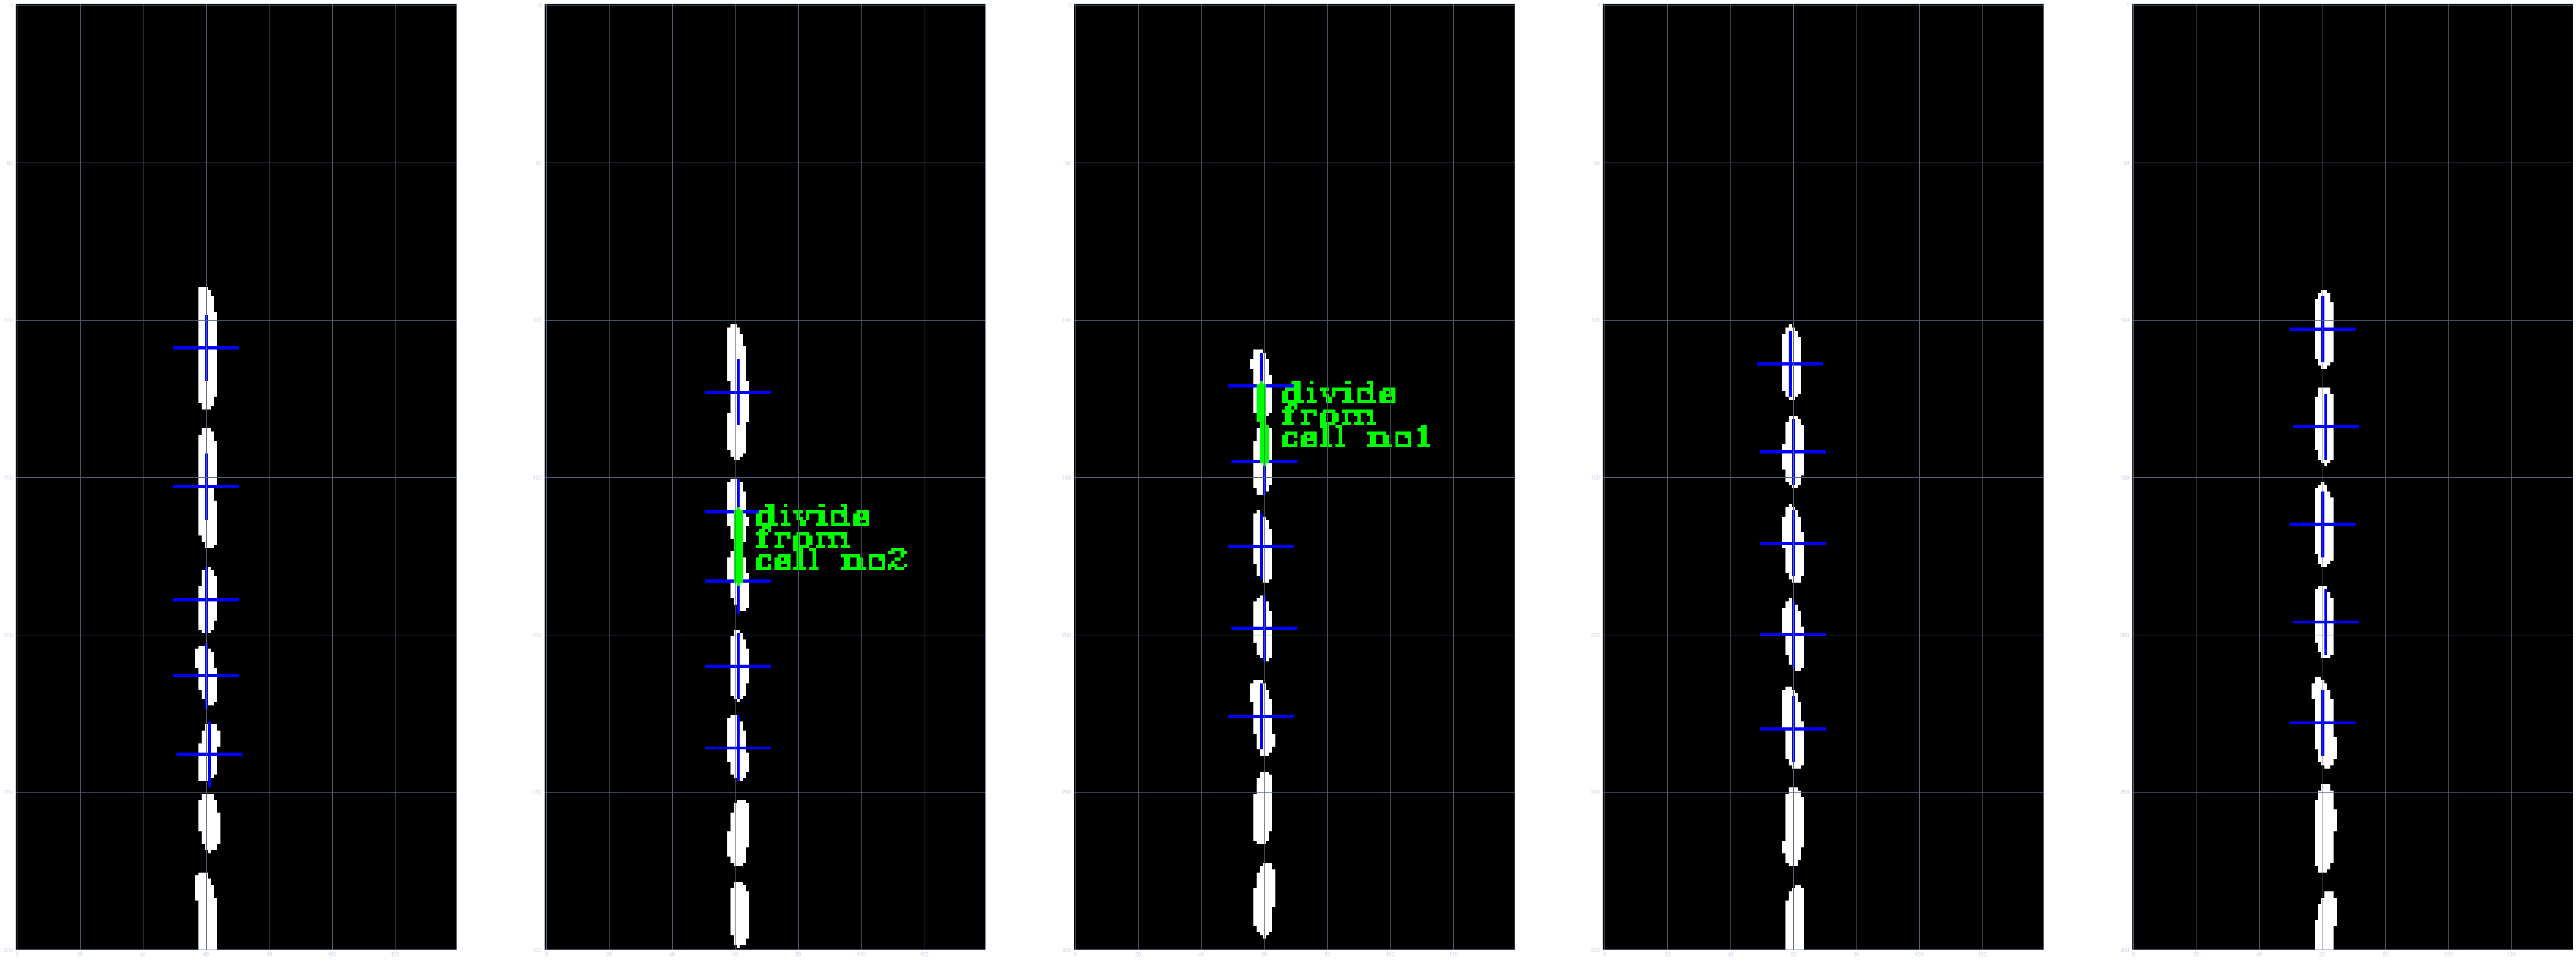

In [17]:
frames = 5

directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)


In [18]:
vis.label_images(mask_dir, mode="landscape-line", 
                 save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\", 
                 template=template_mask)

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr1_masks\landscape_masks\\landscape_line_xy000_mCherry_TR1_T-_epoch-20_prob-99.png


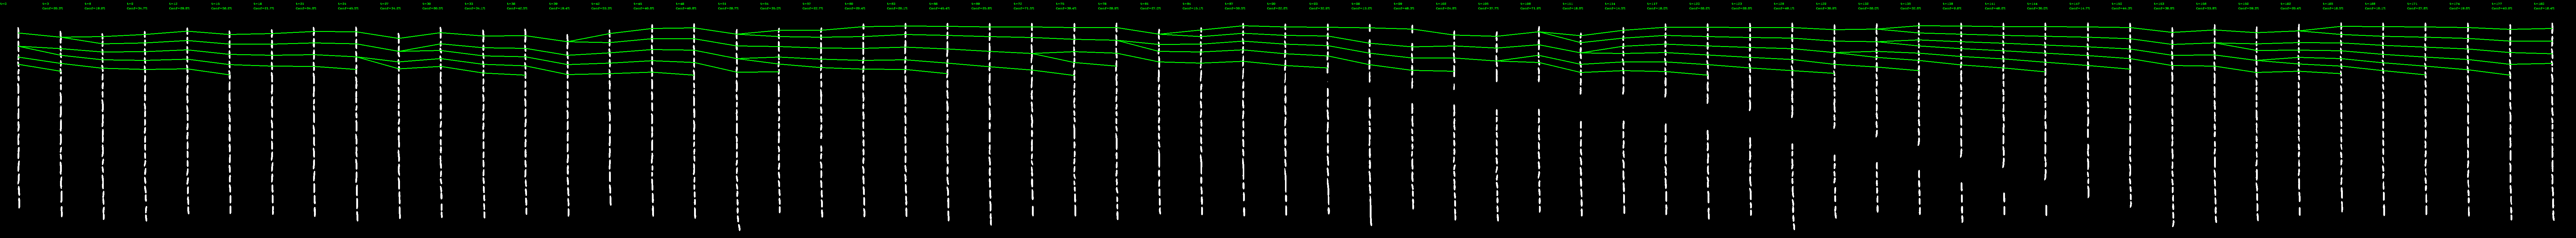

In [19]:
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

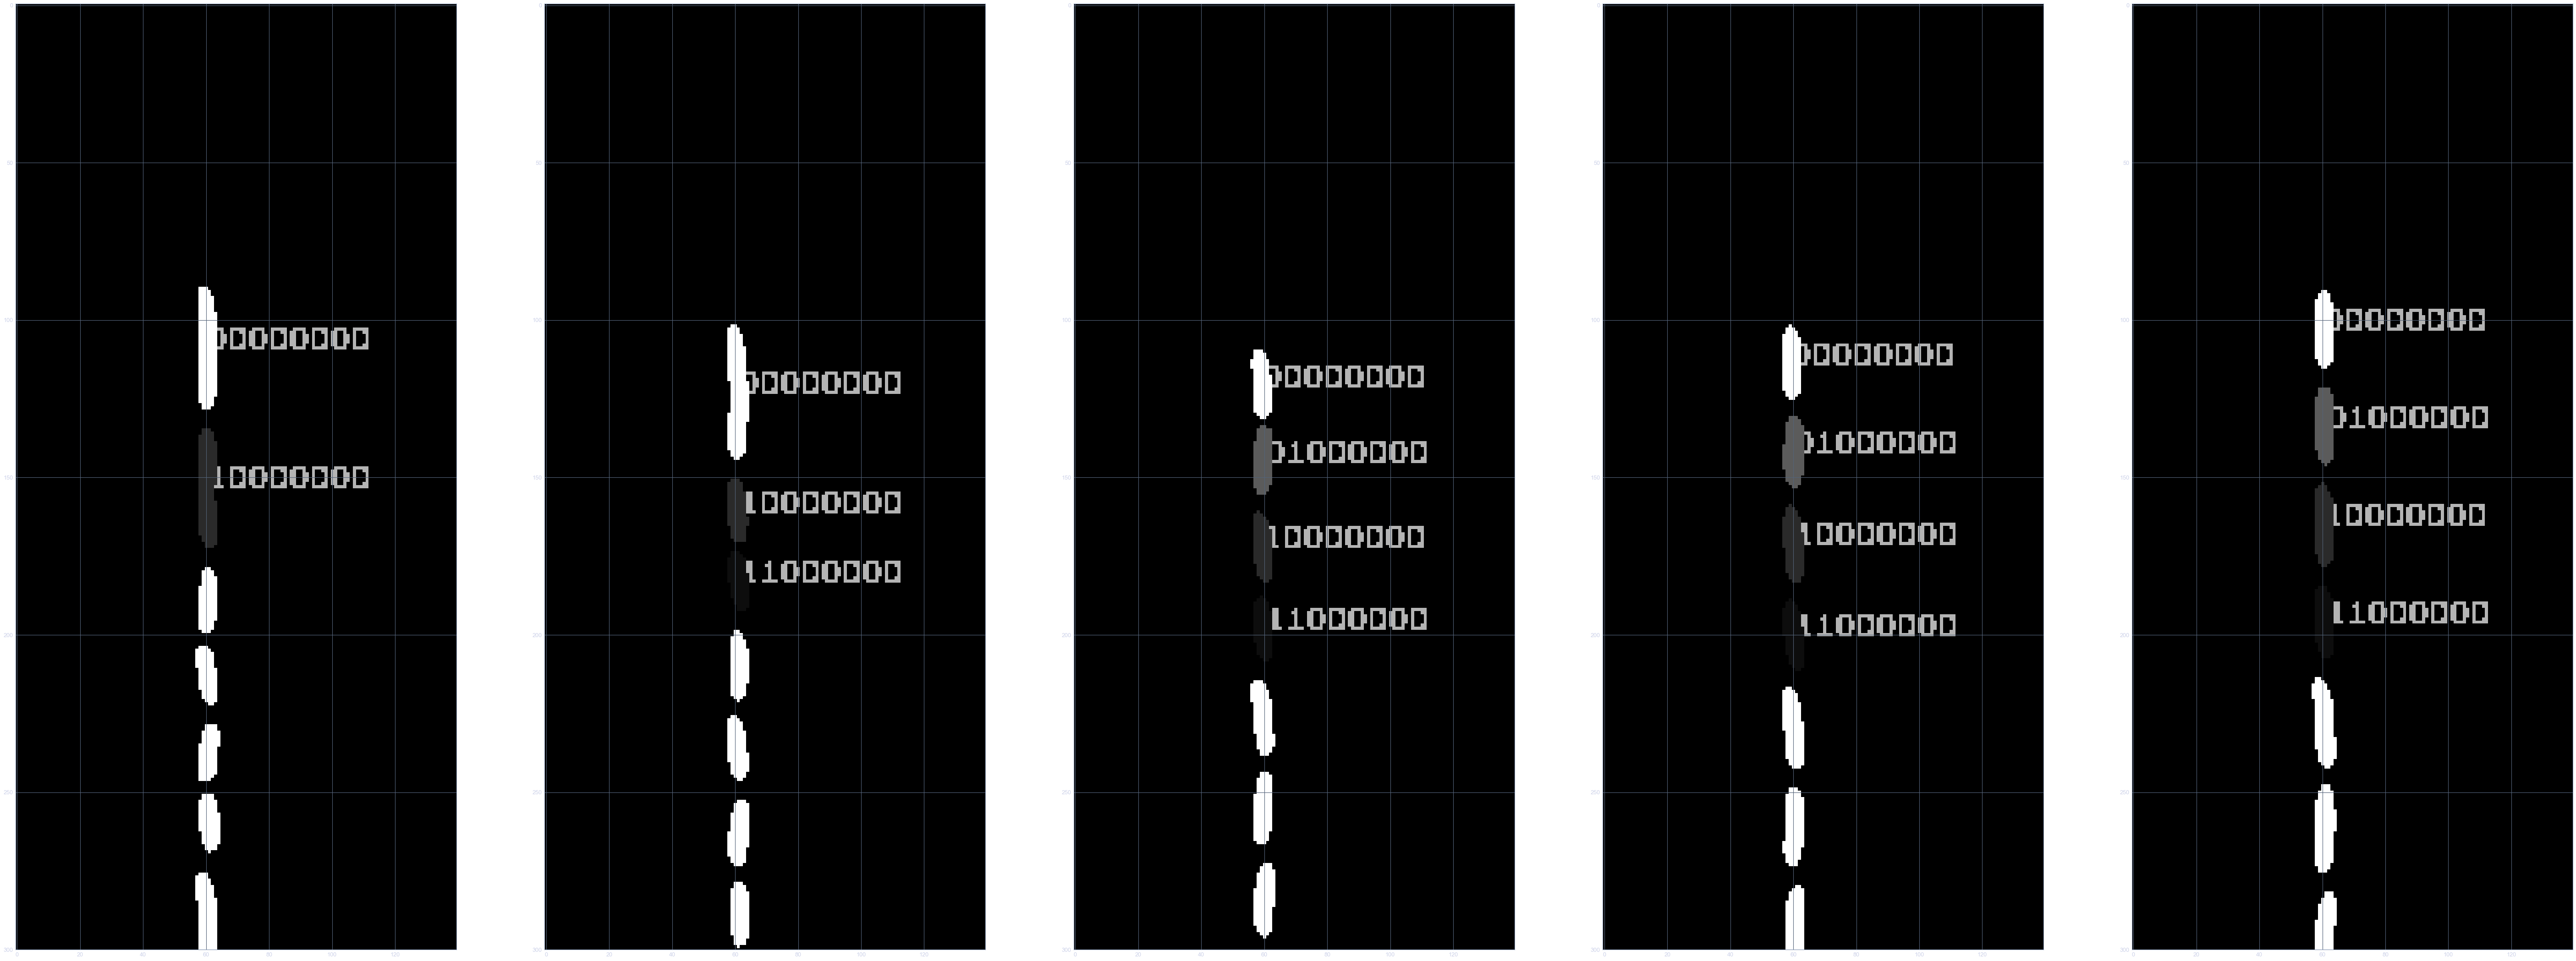

In [20]:
vis.label_images(mask_dir, mode="barcode", 
                 save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\barcoded_masks\\", 
                 template=template_mask, colour_scale="Greys")
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\barcoded_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]

frames = 5
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)

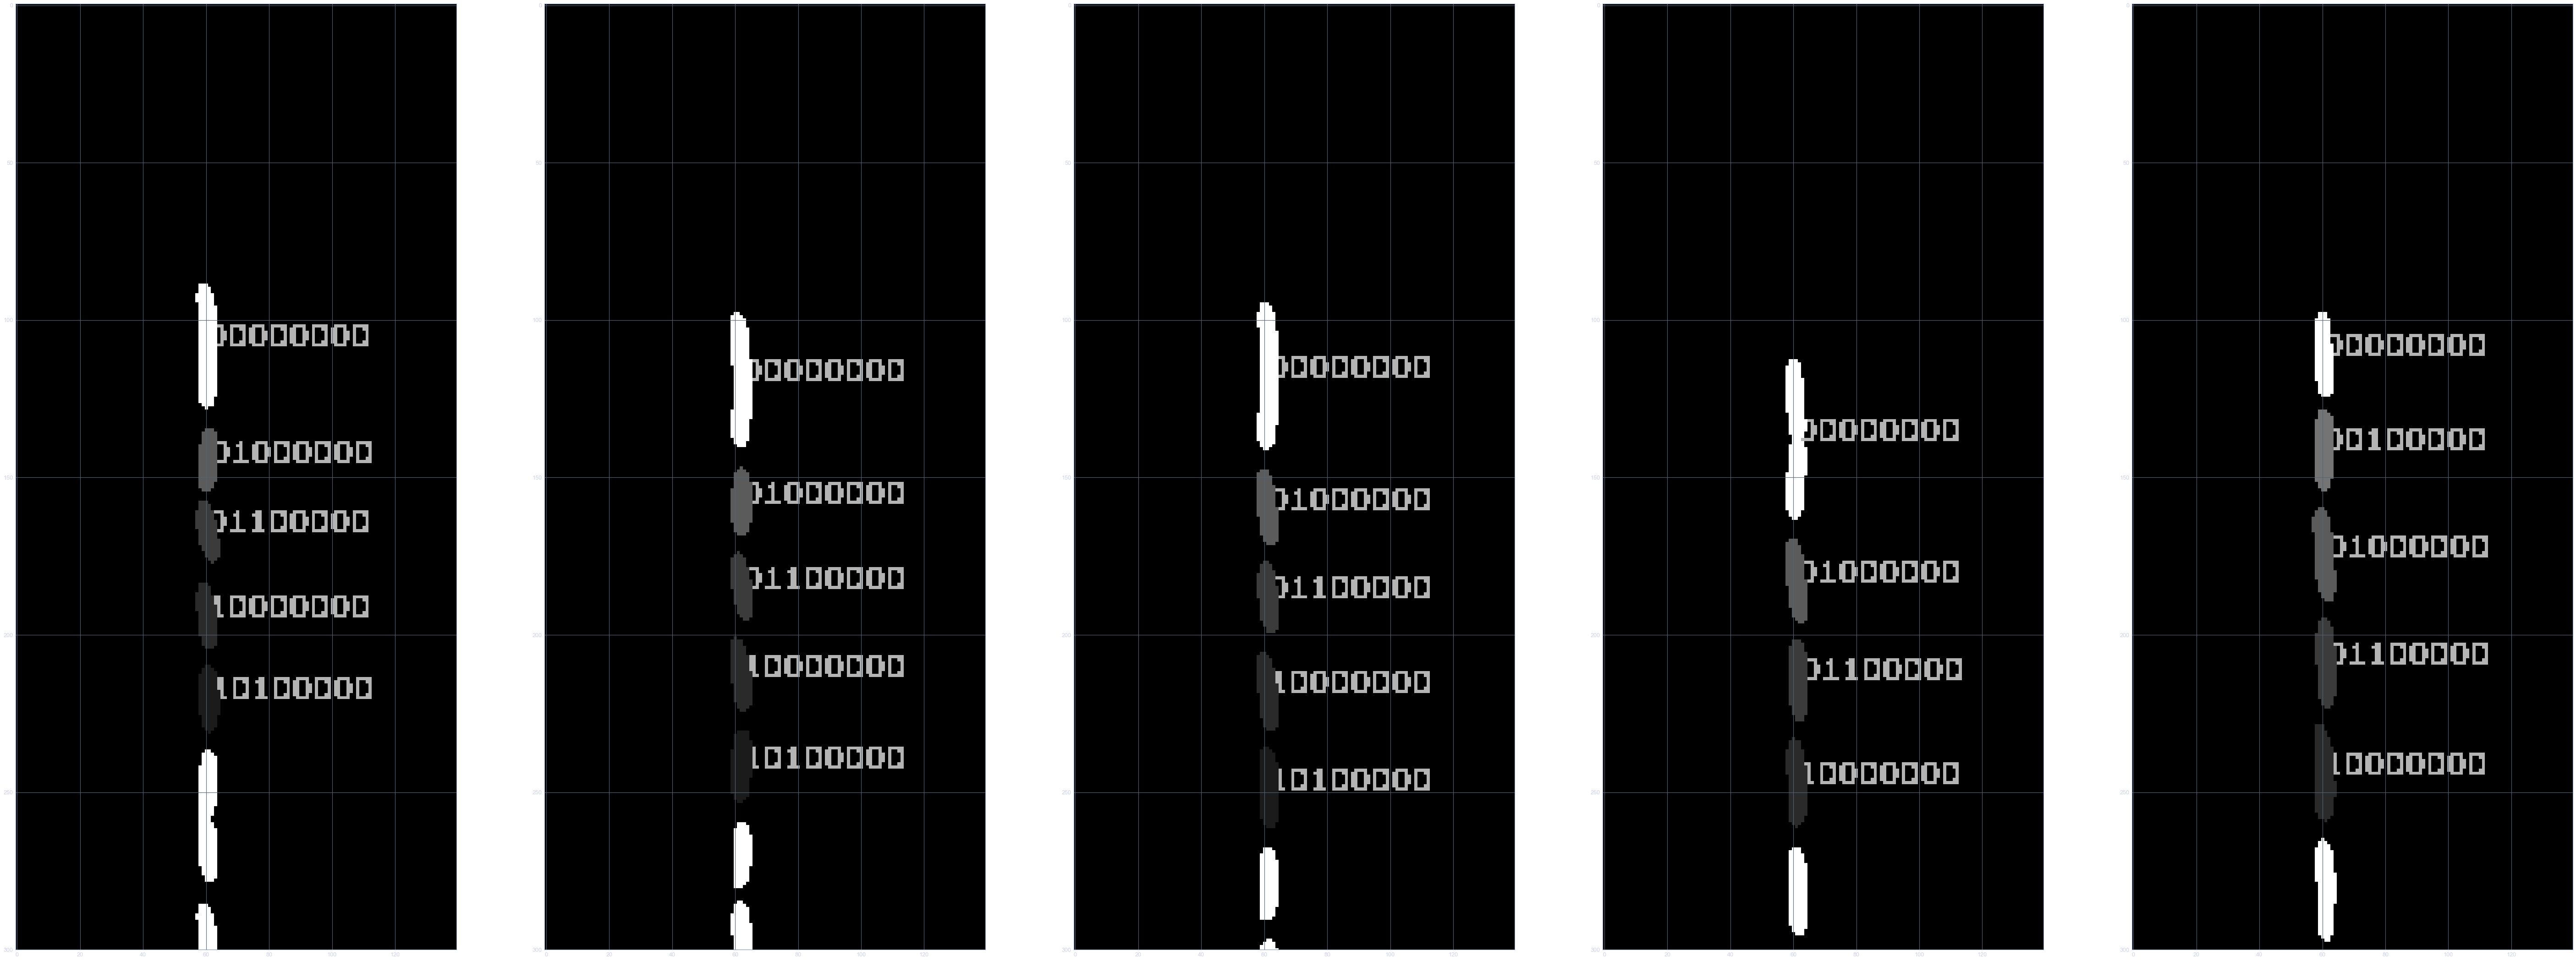

In [21]:
vis.get_labelled_image("F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\barcoded_masks\\",
                       frames=[10, 11, 12, 13, 14], trench=1, pre="barcoded_", 
                       template=template_mask, template_mode="exp")

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr1_masks\landscape_barcode\\landscape_barcode_xy000_mCherry_TR1_T-_epoch-20_prob-99.png


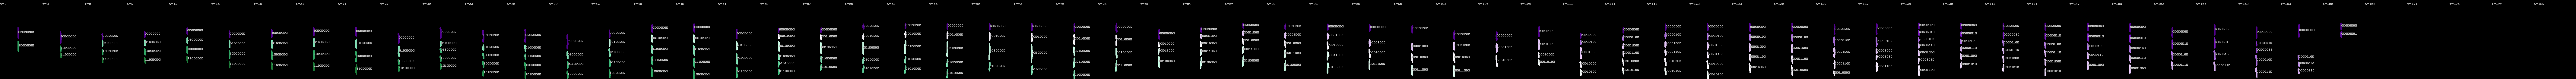

In [22]:
vis.label_images(mask_dir, mode="landscape-colour-scale", 
                 save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_barcode\\", 
                 template=template_mask, show_other=False, for_frames=None, colour_scale="PiYG")

directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_barcode\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

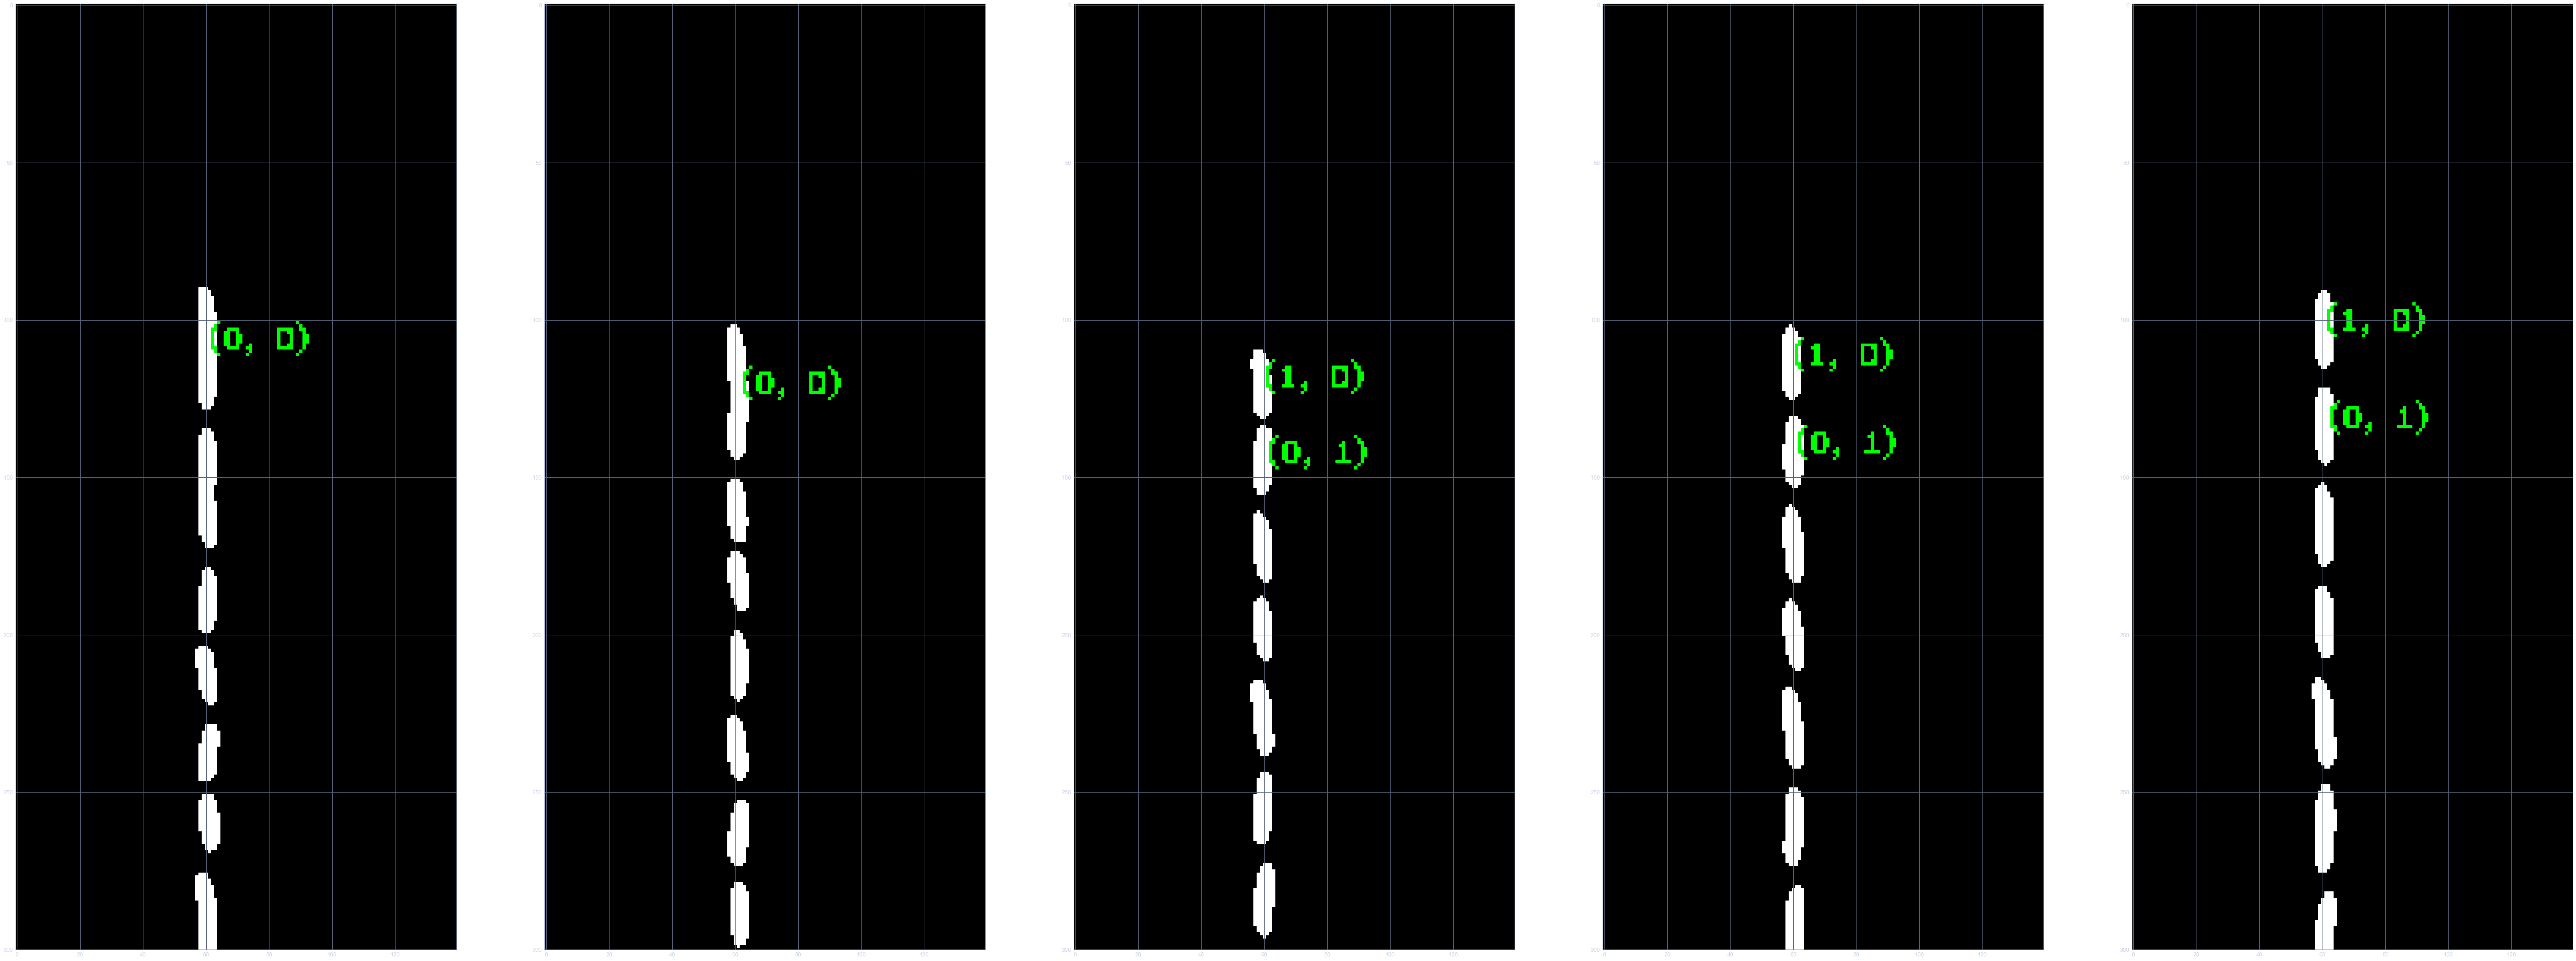

In [23]:
vis.label_images(mask_dir, mode="generation-by-poles", 
                 save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\poles_masks\\", 
                 template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\poles_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]

frames = 5
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)

Test it on another trench and try track more cells:

In [24]:
track_df_2, lysis_df_2 = exp.track_trench(trench=2, threshold=400, max_dpf=3, 
                                          search_mode="SeqMatch", p_sp=0, special_reporter=None, 
                                          show_details=False, ret_df=True)

Tracking over frames in trench 2: 100%|████████████████| 60/60 [00:15<00:00,  3.80it/s]


saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr2_masks\landscape_masks\\landscape_line_xy000_mCherry_TR2_T-_epoch-20_prob-99.png


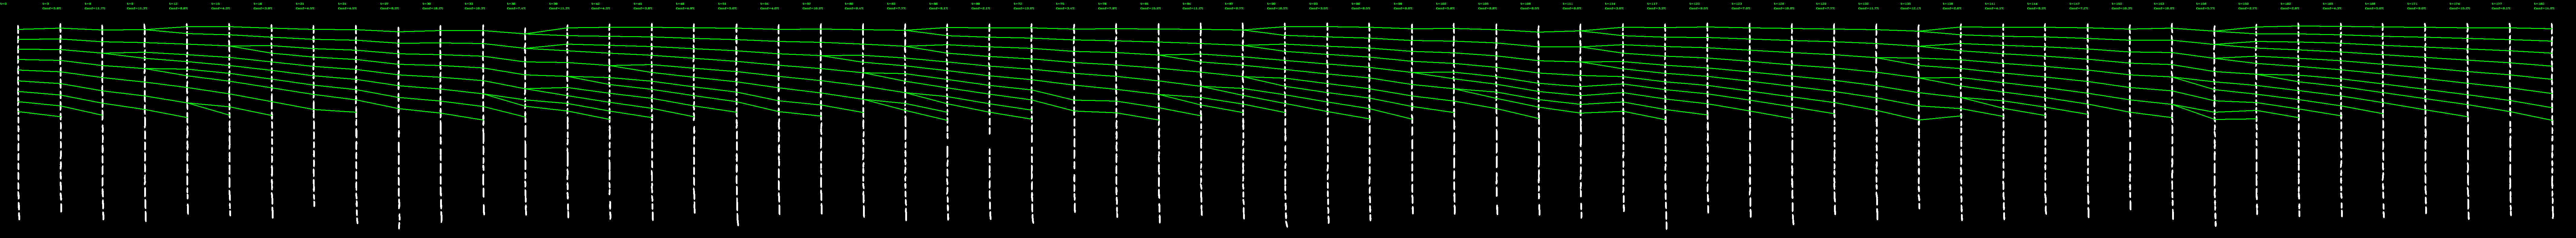

In [25]:
vis_2 = Visualiser("000", track_df_2, lysis_df_2)
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\"
vis_2.label_images(mask_dir, mode="landscape-line", 
                   save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\", 
                   template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))